In [21]:
import pandas as pd
import numpy as np
import gpflow
from gpflow.utilities import print_summary
from gpflow.models import SGPR
import tensorflow as tf
from tensorflow.keras.optimizers import Optimizer
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import geopandas as gpd
%matplotlib inline

In [2]:
aurn = pd.read_csv("data/formatted/aurn_jan1st.csv")
print(aurn.head())

   time   latitude  longitude        val
0     1  50.371670  -4.142361   6.191667
1     1  50.411463  -4.227678   6.429167
2     1  50.735454  -1.780888  10.250000
3     1  50.739570  -1.826744   9.291667
4     1  50.805778   0.271611   5.991667


In [3]:
cams = pd.read_csv("data/formatted/cams_janst.csv")

In [4]:
cams.head()

,lat,lon,pm,time
0,49.8,-10.6,6.074860,0
1,49.9,-10.6,6.093135,0
2,50.0,-10.6,6.187524,0
3,50.1,-10.6,6.289507,0
4,50.2,-10.6,6.357866,0


In [5]:
print(f"Counts:\n\tAURN: {aurn.shape[0]}\n\tCAMS: {cams.shape[0]}")

Counts:
	AURN: 441
	CAMS: 84000


# Fit AURN model

In [6]:
XA = aurn[['latitude', 'longitude', 'time']].values
yA = aurn.val.values.reshape(-1, 1)

In [7]:
def standardise(X):
    Xmean = np.mean(X, axis=0)
    Xstd = np.std(X, axis=0)
    return (X-Xmean)/Xstd, Xmean, Xstd

Xtr, Xmean, Xstd = standardise(XA)

In [8]:
ytr = np.log(yA)
ymean = np.mean(ytr)
ytr_cent = ytr-ymean

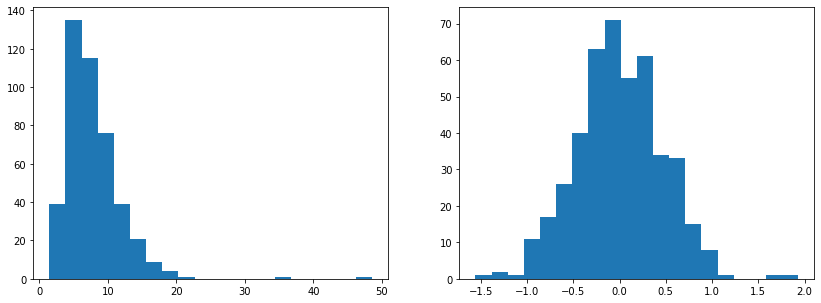

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
ax[0].hist(yA, bins=20);
ax[1].hist(ytr_cent, bins=20);

In [10]:
kern = gpflow.kernels.Matern32(lengthscales=[1/np.sqrt(Xtr.shape[1])]*Xtr.shape[1])
mAurn = gpflow.models.GPR((Xtr, ytr_cent), kernel=kern)
print_summary(mAurn, fmt='notebook')

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,1.0
GPR.kernel.lengthscales,Parameter,Softplus,,True,"(3,)",float64,[0.57735027 0.57735027 0.57735027]
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0


In [11]:
opt = tf.optimizers.Adam(learning_rate=0.005)
nits = 3000
logfs = []

def scheduler(nit):
    if nit > 2500 and nit < 5000:
        return 0.005
    if nit > 5001 and nit < 7500:
        return 0.001
    if nit > 7501:
        return 0.001


for i in range(nits):
#     lr = scheduler(i)
#     opt.learning_rate = lr
    opt.minimize(mAurn.training_loss, mAurn.trainable_variables)
    loss = -mAurn.training_loss().numpy()
    if i % 200 == 0:
        print(f"Step {i}: {loss: .2f}")
    logfs.append(loss)


Step 0: -507.44
Step 200: -342.65
Step 400: -208.45
Step 600: -142.75
Step 800: -128.66
Step 1000: -127.32
Step 1200: -127.16
Step 1400: -127.12
Step 1600: -127.09
Step 1800: -127.06
Step 2000: -127.04
Step 2200: -127.01
Step 2400: -126.99
Step 2600: -126.96
Step 2800: -126.94


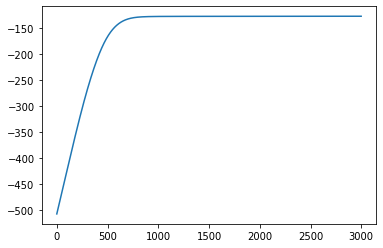

In [12]:
plt.plot(logfs)

In [13]:
print_summary(mAurn, fmt='notebook')

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,0.32432305680928103
GPR.kernel.lengthscales,Parameter,Softplus,,True,"(3,)",float64,[0.88055589 3.64245419 0.84858977]
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.06540194954905176


# Fit CAMS 

In [25]:
def train_sgpr(m: SGPR, nits: int, opt: Optimizer, verbose: bool=False):
    logfs = []
    for i in range(nits):
        opt.minimize(m.training_loss, m.trainable_variables)
        current_loss = -m.training_loss().numpy()
        logfs.append(current_loss)
        if verbose and i%100==0:
            print(f"Step {i}: loss {current_loss}")
    return m, logfs

In [26]:
from scipy.cluster.vq import kmeans2

XC = cams[['lat', 'lon', 'time']].values
yC = cams.pm.values.reshape(-1, 1)

XCtr, XCmean, XCstd = standardise(XC)
Z = kmeans2(XCtr, k=300, minit='points')[0]

yCtr = np.log(yC)
yCmean = np.mean(yCtr)
yCtr_cent = yCtr-yCmean

kern = gpflow.kernels.Matern32(lengthscales=[1/np.sqrt(XCtr.shape[1])]*XCtr.shape[1])
mCams = gpflow.models.SGPR((XCtr, yCtr_cent), kernel=kern, inducing_variable=Z)
print_summary(mCams, fmt='notebook')

opt = tf.optimizers.Adam(learning_rate=0.005)
mCams, logfs_cams = train_sgpr(mCams, 3000, opt, verbose=True)

name,class,transform,prior,trainable,shape,dtype,value
SGPR.kernel.variance,Parameter,Softplus,,True,(),float64,1.0
SGPR.kernel.lengthscales,Parameter,Softplus,,True,"(3,)",float64,[0.57735027 0.57735027 0.57735027]
SGPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0
SGPR.inducing_variable.Z,Parameter,,,True,"(300, 3)",float64,"[[-1.50366218, 1.37806372, -0.29277002..."


Step 0: loss -83242.83633554284


KeyboardInterrupt: 

## Make preds

In [15]:
shp = gpd.read_file("data/UK_boundary_shp/")

In [16]:
XC = (cams[["lat", "lon", "time"]].values-Xmean)/Xstd

In [17]:
mu, sigma = mAurn.predict_y(XC)
mu_tr = np.exp(mu + ymean)
sigma_tr = np.exp(sigma+ymean)

In [18]:
Xretr = (XC*Xstd)+Xmean
preds = pd.DataFrame(np.hstack((Xretr, mu_tr, sigma_tr)), columns=['lat', 'lon', 'time', 'mu', 'sigma'])
preds.head()

,lat,lon,time,mu,sigma
0,49.8,-10.6,0.0,6.688307,10.045836
1,49.9,-10.6,0.0,6.691158,10.024327
2,50.0,-10.6,0.0,6.698184,10.004470
3,50.1,-10.6,0.0,6.709715,9.986513
4,50.2,-10.6,0.0,6.725994,9.970643


In [ ]:
times = preds.time.drop_duplicates().tolist()
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 10))

for time, ax in zip(times, axes.ravel()):
    p = preds[preds.time == time]
    temp = p[['lat', 'lon', 'mu']]
    piv = temp.pivot(index='lat', columns='lon', values='mu')
    im = ax.pcolormesh(piv.columns, piv.index, piv, cmap='viridis')
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    
    shp.boundary.plot(ax = ax)

# TODO

* Check CRS are equal in CAMS and AURN
* Fit both models using MCMC